***

# CDAE
- 아이템의 사용자별 평점 벡터에 대하여 Auto Encoder 방식인 input, output을 재현하는 AutoRec에서 in/out 벡터에 denoising을 주고, 사용자의 bias텀을 추가한 방식으로 선호 순위를 예측하는 기법

### - Reference: [Collaborative Denoising Auto-Encoders for Top-N Recommender Systems](https://alicezheng.org/papers/wsdm16-cdae.pdf)

### - Prediction:
사용자u에 대한 아이템들의 평점벡터 $y_{i}$는 아래와 같이 예측
<center> $\hat{y_{u}} = f(W'^Tz_u+b'), z_u = h(W^T\tilde{y_u}+V_u+b)$ </center>

|expression|mean|
|:---:|:---:|
|$$y_{i}=(r_{u1}, r_{u2}, ..., r_{um})$$|사용자 u의 아이템들의 평점 벡터|
|$W$, $W'$|인코더 레이어,디코더 레이어|
|$h(\cdot), f(\cdot)$| 인코더, 디코더 레이어의 활성화 함수, sigmoid, relu등이 사용될 수 있음|
|$b, b'$|인코더, 디코더 레이어의 bias|
|$V$|사용자 임베딩벡터|
|$\tilde{y_u}$|denoising된 $y_{u}$의 벡터|

- denoising 방법
    - $y_i$의 원소중 0이 아닌 값에 대하여 아래와 같이 변환

        1) $q$의 확률로 원소를 0으로 변환

        2) $1-q$의 확률로 원소를 기존값에 $\delta=1/(1-q)$를 곱한 값으로 변환

### - Optimization:
관측된/ 관측되지 않은 평점벡터에 대하여 binary cross entropy를 목적함수로 하여 파라미터를 추정</br>
인코더 레이어 $W$의 가중치는 관측된 평점에 대하여 계산된 그래디언트만 반영하여 가중치를 업데이트</br>
디코더 레이어 $W'$의 가중치는 관측되지 않은 평점을 임의추출하여 관측된/관측되지 않은 평점에 대하여 계산된 그래디언트를 반영하여 가중치를 업데이트</br>
</br>
논문에서는 평점이 4이상인 것만 1, 그렇지 않으면 0으로 implicit feedback을 생성하였음</br>
평점이 5개 미만인 아이템과 사용자는 제거하였음</br>
관측되지 않은 평점을 임의추출하는 개수는 관측된 평점의 5배로 하였음</br>
    
### - Evaluation:
<center> $AP@N = \frac{sum_{k}Precision@k*rel(k)}{min\{N,|C_{adopted}|\}}$ </center>
    
|split|measure|
|:---:|:---:|
|holdout|MAP|

***

## Import library

In [23]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from Generator.MatrixGenerator import MatrixGenerator
from Models.CDAE import CDAE

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

***

## 1) Datat processing

### load data

In [7]:
ratings = pd.read_csv('../data/movie_lens/ratings.csv',
                      names=['user_id', 'item_id', 'rating', '_'],
                      skiprows=1).drop(columns=['_'])
ratings

,user_id,item_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


### remain data if rating>4 & convert explicit feedback to implicit feedback

In [8]:
is_upper_thr = ratings['rating'] >= 4
remain_idx = is_upper_thr[is_upper_thr==True].index
ratings = ratings.loc[ratings.index.isin(remain_idx)==True]
ratings['rating'].values.fill(1)
ratings

,user_id,item_id,rating
0,1,1,1.0
1,1,3,1.0
2,1,6,1.0
3,1,47,1.0
4,1,50,1.0
...,...,...,...
100830,610,166528,1.0
100831,610,166534,1.0
100832,610,168248,1.0
100833,610,168250,1.0


### remain data if count>5 per items, users

In [10]:
while True:
    if (min(ratings.groupby('item_id').count()['user_id']) >= 5) and\
       (min(ratings.groupby('user_id').count()['item_id']) >= 5):
        break

    lower_item_per_user = ratings.groupby('user_id').count()['item_id']<5
    remove_user_ids = lower_item_per_user[lower_item_per_user==True].index
    ratings = ratings[ratings.user_id.isin(remove_user_ids)==False]

    lower_user_per_item = ratings.groupby('item_id').count()['user_id']<5
    remove_item_ids = lower_user_per_item[lower_user_per_item==True].index
    ratings = ratings[ratings.item_id.isin(remove_item_ids)==False]
    
ratings

,user_id,item_id,rating
0,1,1,1.0
1,1,3,1.0
2,1,6,1.0
3,1,47,1.0
4,1,50,1.0
...,...,...,...
100829,610,164179,1.0
100830,610,166528,1.0
100832,610,168248,1.0
100833,610,168250,1.0


### conver id to index

In [11]:
user_ids = ratings['user_id'].unique().tolist()
item_ids = ratings['item_id'].unique().tolist()

num_user = len(user_ids)
num_item = len(item_ids)

id_to_index_user = {user_ids[i] :i for i in range(num_user)}
id_to_index_item = {item_ids[i] :i for i in range(num_item)}

ratings['user_id'] = ratings['user_id'].apply(lambda x: id_to_index_user[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: id_to_index_item[x])

ratings

,user_id,item_id,rating
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
...,...,...,...
100829,600,833,1.0
100830,600,531,1.0
100832,600,1357,1.0
100833,600,1358,1.0


### split data

In [12]:
val_ratio = 0.1
test_ratio = 0.2
seed = 1234

train, others = train_test_split(ratings,
                                 test_size=val_ratio+test_ratio,
                                 shuffle=True,
                                 random_state=seed)

validation, test = train_test_split(others,
                                    test_size=test_ratio/(val_ratio+test_ratio),
                                    shuffle=True,
                                    random_state=seed)

print(f"# of observation(train/val/test): {len(train)}, {len(validation)}, {len(test)}")

# of observation(train/val/test): 28858, 4123, 8246


### set config & get dataset from generator

In [36]:
class DatasetConfig:
    num_negative = 5
    between_observed= False
    batch = 128

dataset_config = DatasetConfig()

In [37]:
dataset = MatrixGenerator(train_data=train,
                          n_user=num_user,
                          n_item=num_item,
                          config=dataset_config)

### see example data for a batch

In [38]:
train_loader = DataLoader(dataset, batch_size=2)
data1, data2, data3 = next(iter(train_loader))

(1) [user id X batch_size]

In [39]:
data1

tensor([0, 1])

(2) [ [$rating_{u,1}$, ..., $rating_{u, m}$] X batch_size]

In [40]:
data2

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(3) [ [$implicit_{u,1}$, ..., $implicit_{u, m}$] X batch_size]

In [41]:
data3

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

***

## 2) Modeling

### set config & get model

In [42]:
class OptimizerConfig:
    method = 'Adam'
    regulation = 1e-5
    learning_rate = 0.01
    learning_decay = 0.95

class ModelConfig:
    epochs = 50
    print_step = 5

class CDAEConfig:
    evaluation = 'MAP'
    k = 10
    dim_latent = 300
    corrupt_ratio = 0.6

optimizer_config = OptimizerConfig()
cdae_config = CDAEConfig()
model_config = ModelConfig()

In [43]:
inputs = {"n_user":num_user,
          "n_item":num_item}

model = CDAE(inputs, model_config, optimizer_config, cdae_config)

[BaseModel] method = Adam
[BaseModel] regulation = 1e-05
[BaseModel] learning_rate = 0.01
[BaseModel] learning_rate_decay = 0.95


### fit model & see loss and performance

In [44]:
train_loader = DataLoader(dataset, batch_size=dataset_config.batch)
model.fit(train_loader=train_loader, val_data=validation)


[CDAE]============================================== Train ===============================================
[CDAE]              (train: BCE)        (validation: MAP)   
          (epoch 5) 0.0033              0.1005              
         (epoch 10) 0.0037              0.0817              
         (epoch 15) 0.0038              0.0906              
         (epoch 20) 0.0039              0.0936              
         (epoch 25) 0.0039              0.0942              
         (epoch 30) 0.0039              0.0903              
         (epoch 35) 0.0039              0.0944              
         (epoch 40) 0.0039              0.1038              
         (epoch 45) 0.0039              0.1054              
         (epoch 50) 0.0039              0.0976              


***

## 3) Evaluation

### evaluate testset

In [45]:
model.test(train_loader=train_loader, test_data=test)


[CDAE]============================================= Evaluate =============================================
[CDAE] (test: MAP) = 0.1370


### see plot for loss and performance

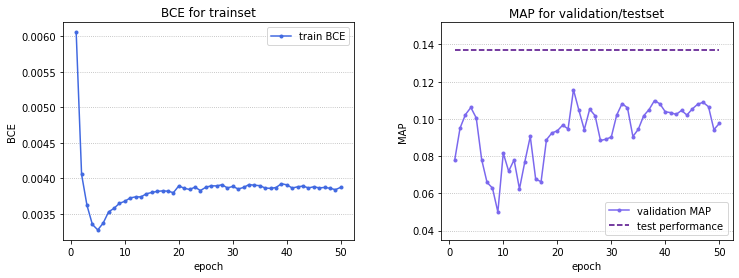

In [46]:
figure = model.draw_plot()
plt.show()